# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm?

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ 

I work in telecommunications industry in the area that enables the Internet. The network nodes (IP Routers) can be represented as connected graphs. They are generally "directed" graphs in the sense that you can have different metrics (costs) in each direction (Say A & B has fiber optic link, with A->B having a cost of 1, and B->A having a cost of infiniy so you remove B->A from the graph representation). It is also a common technique in some scenarios to represent them as "undirected", meaning they are bi-directional connections with same cost in either direction ( typically number of hops is the cost). As a matter of fact, Dijkstra's algorithm is very popular in data networks and is widely used in small segments to compute shortest path.

The "in-degree" represents the number of edges incoming to a vertex. In the example I stated above, the in-degree can vary dependending on where the router is placed. Edge of the network, the in-degree can be 0 or single digit and at the core of the network the in-degree can run into 10s/hundreds (i.e, >100 nodes can connect to a given node).

Other examples of graph representation is the organization chart with nodes representing individual employees and edges representing the managerial relationship. This is a directed graph with the direction being from manager to their direct reports. The in-degree in this case will be typically 1, because an employee will have only 1 supervisor.


> __b)__  

The requirement of propagating the computed result and current state at each stage of graph traversal is very challenging in map-reduce. For example, Dijkstra's algorithm in graphs requires priority queue that maintains a globally sorted list of nodes by current distance. This is not possible in traditional map-reduce that does not allow exchanging global data. While it is possible in Spark, it is expensive if the scale is large.

> __c)__ 

Dijkstra's algorithm is used for calculating shortest paths from any given node to other nodes in the graph. As I cited in example "a", the goal is to find the shortest path to the destinations, considering the weights and not just the hops. The input to the algorithm is directed connected graph with adjacency lists. The initial distances are set to infinity, except to self which is 0. The algorithm also requires a global priority queue of vertices with priorities equal to their distance values. The algorithm then iteratively selects the nodes with the lowest current distance from the priority queue [This is key for priority queue as it is no longer FIFO]. At each iteration, the algorithm expands that node by traversing the adjacency list of the selected node to see if any of those nodes can be reached with a path of a shorter distance. The algorithm terminates when the priority queue is empty.

The requirement of maintaining global prioty queue is the main challenge that makes it hard to parallelize. This queue needs to be broadcasted which is not possible in all the frameworks, and also becomes a scaling challenge for huge graphs [FB, web pages etc.]

> __d)__ 

Parallel breadth-first search is an iterative algorithm, where each iteration corresponds to a MapReduce job. Each iteration of the algorithm expands the “search frontier” by one hop, and, eventually, all nodes will be discovered with their shortest distances. We need to pass-along the graph structure from one iteration to the next.

The algorithm is a brute force approach that “wastes” a lot of time performing computations whose results are discarded. At each iteration, the algorithm attempts to recompute distances to all nodes, but in reality only useful work is done along the search frontier. Inside the search frontier, the algorithm is simply repeating previous computations.


# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.


### Q2 Student Answers:
> __a)__ 

The graph in figure 5.1 is "sparse" as there are limited number of edges. In general, a graph is sparse if the number of connections are far lesser than full-mesh of connections.

The adjacency list for a sparse graph will be much smaller compared to a dense graph. Adjacency matrix of a sparse graph will have lot of 0s as opposed to a dense representation. 

> __b)__ 

This graph is "directed" becuase each edge represents uni-direction. The adjacency matrix for a undirected graph will be symmetric along the diagonal. For a directed graph it will not be symmetric along the diagonal.



In [5]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

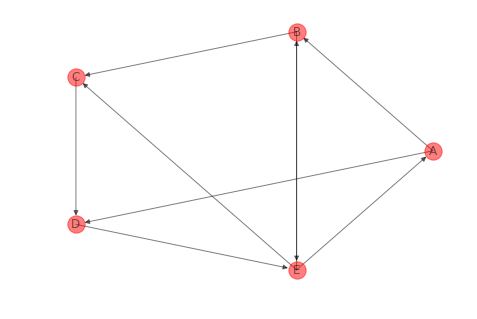

In [6]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [7]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for (row, column) in graph['edges']:
        adj_matr[column][row] = 1    
    ############### (END) YOUR CODE #################
    return adj_matr

In [8]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [8]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for (row, column) in graph['edges']:
        adj_list[row].append(column)
    
    ############### (END) YOUR CODE #################
    return adj_list

In [10]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ 

In terms of a random walk by web surfer through the hyper links, PageRank represents how frequently the walker would encounter the given web page if he continues to walk around the links tirelessly. More precisely mentioned by Lin & Dyer in 5.3, PageRank is a probability distribution over nodes in the graph representing the likelihood that a random walk over the link structure will arrive at a particular node.

> __b)__ 

One of the key properties of Markov chain process is that it has no memory of the past. i,e, the probability of arriving at the next web page is solely depdendent on the current page. This memoryless state is referred to as Marlov Property. 

In the context of page rank, in addition to considering the markov transition matrix for ranking the page, we also consider teleportation factor where a surfer can teleport or randomly jump to another page, with a random jump factor of $\alpha$

> __c)__ 

Landing at each webpage is considered as a state. For webgraph n represents the number of web pages (vertices) in the web. The transition matrix (nxn) can be very large size if the number of web pages are large. Hence, computing page rank on a single compute becomes extremely challenging due to the large scale of matrix operation involved. It requires distributed computing in the form of map reduce framework.

> __d)__ 

A right stochastic matrix is a real, positive square matrix where each row sums to "1". All the entries are greater than or requal to 0 (positive and real). 

> __e)__ 

To match the stable distribution matrix of 8 decimals, it took about 5 iterations. Node 'E' has got the highest rank. Node E has got the highest out-degree (3) and a in-degree of 2. My initial intution was that the node with more in-degree would have higher rank as it would get more mass. Four of the five have same in-degree 2. So, it was difficult to judge based on in-degree alone. But on closer look, one of the contributions to E is coming from 'D' which has only one edge. D gives its entire mass to E.  Thus, I thought E must be the winner before computing the same.

In [11]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [12]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
# Column represents "FROM" and Row represents "TO"
# We need to add the column to get the number of nodes we can go from given node.
# Then divide the given cell by that sum to get the probability distribution

transition_matrix = TOY_ADJ_MATR.apply(lambda x: x/float(x.sum()), axis=1)

################ (END) YOUR CODE #################
print(transition_matrix)

          A         B         C    D    E
A  0.000000  0.500000  0.000000  0.5  0.0
B  0.000000  0.000000  0.500000  0.0  0.5
C  0.000000  0.000000  0.000000  1.0  0.0
D  0.000000  0.000000  0.000000  0.0  1.0
E  0.333333  0.333333  0.333333  0.0  0.0


In [12]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    # initialize state vector with xInit
    state_vector = xInit
    # Initialize the power vector to transition matrix
    power_vector = tMatrix
    for i in range(1, nIter+1):
        # Multiply the transition matrix by itself
        power_vector = np.matmul(power_vector,power_vector)
        # Calculate the state vector
        state_vector = np.matmul(state_vector,power_vector)
        if verbose : 
            print("step:", i)
            print(state_vector)       
    
    ################ (END) YOUR CODE #################
    return state_vector

In [14]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

step: 1
[0.   0.   0.25 0.   0.75]
step: 2
[0.14583333 0.20833333 0.20833333 0.25       0.1875    ]
step: 3
[0.10746206 0.15780928 0.18477929 0.23268711 0.31726225]
step: 4
[0.10525876 0.15789576 0.18420955 0.23685181 0.31578413]
step: 5
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
step: 6
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
step: 7
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
step: 8
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
step: 9
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
step: 10
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]


__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.


### Q4 Student Answers:
> __a)__ 

The transition matrix is no longer right stochastic matrix as the row 'E' does not sum to 1. This is because node 'E' is a dangling node, hence there are no outgoing probabilty mass in our current approach to the'not nice' graph. If it is not a stochastic matrix, markov chains and transitions cannot be applied.

> __b)__ 

As explained in part 'a', E is the dangling node with no out-degree. This results in the transition matrix to be not stochastic. The sum of any given row must add up to 1 in the transition matrix. To address the dangling node problem, we must assign equal probability from the dangling node to each of the other node (since we have 5 nodes, a probability of 1/5 for every node starting from E). This implies that we are distributing the mass to all the nodes equally from E.

> __c)__ 

An irreducible graph has a path from every node to every other node (i.e, no dangling nodes). Webgraphs are generally not irreducible because we cannot reach every web link from a given page. There are a lot of dangling nodes in real life webgraph, where we reach a dead end and not have path to any other web page. 

> __d)__ 

Say our graph has multiple cyclic connections (Cycle1 with 5 nodes: A->B->C->D->E->A, Cycle2 with 6 nodes: E->F->G->H->I->D->E both belonging to the same graph). This directed graph is aperiodic if there is no integer k > 1 that divides the length of every cycle of the graph (5 and 6 in the example I cited above can be only divisible by 1). Equivalently, a graph is aperiodic if the greatest common divisor of the lengths of its cycles is one; this greatest common divisor for a graph G is called the period of G.

The webgraph is not naturally aperiodic. There will be many pages that point to each other forming cycles, and it might result in them being aperiodic. Taking the example from sync notebook, say we have 3 web pages (A<---B<--->C). This will never converge because we have two cycles of 2 nodes each (GCD=2).

> __e)__ 

Page rank overcomes this limitation by assigning a damping factor that allows teleporting from any page to other links even if it has no outgoing edges. The damping factor p reflects the probability that the surfer quits the current page and "teleports" to a new one. Since he/she can teleport to any web page, each page has 1/n probability to be chosen [n=number of pages]. 

From random surfer point of view, this implies that every page can be reached from any given page.


In [10]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

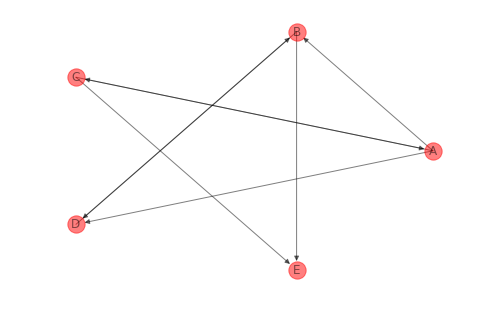

In [16]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [13]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY2_adjacency_matrix = get_adj_matr(TOY2_GRAPH)
#toy2_transition_matrix = TOY2_adjacency_matrix.apply(lambda x: x/(x.sum() * 1.0), axis=1)
toy2_transition_matrix = np.apply_along_axis(lambda x: x/np.sum(x) if np.sum(x)!=0 else 0, 1, TOY2_adjacency_matrix)

print(TOY2_adjacency_matrix)
print(toy2_transition_matrix)

x_Init = np.array([0.5, 0.5, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(x_Init, toy2_transition_matrix, 10, verbose = True)

################ (END) YOUR CODE #################

   A  B  C  D  E
A  0  1  1  1  0
B  0  0  0  1  1
C  1  0  0  0  1
D  0  1  0  0  0
E  0  0  0  0  0
[[0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.         0.5        0.5       ]
 [0.5        0.         0.         0.         0.5       ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
step: 1
[0.08333333 0.41666667 0.         0.08333333 0.16666667]
step: 2
[0.00231481 0.12268519 0.         0.03009259 0.03240741]
step: 3
[1.78612254e-06 7.81071388e-03 0.00000000e+00 1.95223194e-03
 1.95401806e-03]
step: 4
[1.06341125e-12 3.05175771e-05 0.00000000e+00 7.62939400e-06
 7.62939506e-06]
step: 5
[3.76947826e-25 4.65661287e-10 0.00000000e+00 1.16415322e-10
 1.16415322e-10]
step: 6
[4.73632211e-50 1.08420217e-19 0.00000000e+00 2.71050543e-20
 2.71050543e-20]
step: 7
[7.47758237e-100 5.87747175e-039 0.00000000e+000 1.46936794e-039
 1.46936794e-039]
step: 8
[1.86380794e-199 1.72723371e-077 0

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [18]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

In [19]:
# download the test data set (RUN THIS CELL AS IS)
!wget -q -O data/test_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt?dl=0

In [20]:
# take a look
!cat data/test_graph.txt

2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}


In [ ]:
!cat data/test2_graph.txt

In [21]:
# download the main data set - this may take a little time (RUN THIS CELL AS IS)
!wget -O data/wiki_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0

--2019-03-16 04:30:11--  https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt [following]
--2019-03-16 04:30:11--  https://www.dropbox.com/sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4df77cd57f4f814bc4f3375069.dl.dropboxusercontent.com/cd/0/inline/AdLlZ96vVRaNQbCAYdyorvjsbNyE72z-lSq-21466ZLiFf2SjA2K1eBx1QULO3oqrVpgv_TI1XYPp4zbf2jWflKm5HtCSzFNd3z_D6zwho-Lono2_-_wkbfiP4ercBABl5U/file# [following]
--2019-03-16 04:30:12--  https://uc4df77cd57f4f814bc4f33750

In [22]:
# take a look (RUN THIS CELL AS IS)
!head data/wiki_graph.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}
2570	{'983991': 1}
2616	{'9045350': 1}
2711	{'752887': 1}
2818	{'3534183': 1}
2847	{'3797918': 1}
2892	{'2893': 1}
2921	{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}


In [23]:
# download the indexes (RUN THIS CELL AS IS)
!wget -q -O data/indices.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADSYhyRXbgebRDy6ALl6O1ca/wikipedia/indices.txt?dl=0

In [24]:
# take a look (RUN THIS CELL AS IS)
!head data/indices.txt

! $var = &quot;&quot;	1	1	0
! (CONFIG.SYS directive)	2	1	1
! (album)	3	12	17
! (disambiguation)	4	1	20
! -attention-	5	1	0
! Time Zone	6	1	0
!! (chess)	7	0	1
!! (disambiguation)	8	3	0
!!! (Chk Chk Chk)	9	1	0
!!! (album)	10	5	15


In [60]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('gs://dataproc-4c6992fd-4773-46dc-bd20-76cae448be52-us/data/test_graph.txt')
test2RDD = sc.textFile('gs://dataproc-4c6992fd-4773-46dc-bd20-76cae448be52-us/data/test2_graph.txt')
indexRDD = sc.textFile('gs://dataproc-4c6992fd-4773-46dc-bd20-76cae448be52-us/data/indices.txt')
wikiRDD = sc.textFile('gs://dataproc-4c6992fd-4773-46dc-bd20-76cae448be52-us/data/wiki_graph.txt')

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ 

The raw data is an adjacency list. The first value is the webpage index, the second part is the list of indexes of its connected web pages along with their weights which represents the number of times each of the adjacent web page is referenced.

> __b)__ 

Counting the number of records does not give us the dangling nodes which do not have any adjacency. 

> __d)__ Type your answer here!  

Total number of dangling nodes = 15192277 - 5781290 = 9410987

In [30]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
!wc -l data/wiki_graph.txt

5781290 data/wiki_graph.txt


In [37]:
# Define parser which splits each line by tab and returns nodes and edges
def parse(line):
    node, edges = line.split('\t')
    return (node, ast.literal_eval(edges))

# Test values
temp = testRDD.map(lambda x: parse(x))
temp.take(12)

[('2', {'3': 1}),
 ('3', {'2': 1}),
 ('4', {'1': 1, '2': 1}),
 ('5', {'4': 1, '2': 1, '6': 1}),
 ('6', {'2': 1, '5': 1}),
 ('7', {'2': 1, '5': 1}),
 ('8', {'2': 1, '5': 1}),
 ('9', {'2': 1, '5': 1}),
 ('10', {'5': 1}),
 ('11', {'5': 1})]

In [38]:
# part c - write your Spark job here (compute total number of nodes)

def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def emit_node(line):
        """ Emits nodes """    
        # We cannot just emit 'nodes' because there are dangling nodes with no edges.
        # For example, in toy set, node '1' has no edges. So if we naively count nodes, we will miss those nodes
        # Emit both nodes and edges

        node,edges = line
        yield(node)
        for edge in edges:
            yield(edge)
    totalCount = dataRDD.map(lambda x: parse(x)) \
                        .flatMap(emit_node) \
                        .distinct()\
                        .count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [40]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.43659496307373047 seconds.
Total Nodes: 11


In [41]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 126.89571928977966 seconds.
Total Nodes: 15192277


# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ 

out-degree provides the distribution of probability mass of a given node to its connected neighbors. For example, if a node has out-degree of 3, its probability mass is 1/3 towards each node. In other words, a node's rank depends on the out-degree of its incoming nodes.

> __c)__ 

If a node's out-degree is 0, it is considered as dangling node. In PageRank, we distribute the probability mass of such a node to all the nodes equally. If the size of the graph is N, we assign 1/N probability mass to each node from the dangling node. In the case of non-dangling node, the probability mass is distributed only to the outgoing neighbors.

In [42]:
# part a - write your Spark job here (compute average in-degree, etc)


def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    
    def count_edges(line):
        """ Function to count the edges"""
        node,edges = line
        # We need to consider the counts as well, not just the number of edges
        # Hence, adding the values to reflect the same.
        yield(node,sum(edges.values()))
    
    outDegreeRDD = dataRDD.map(lambda x: parse(x))\
                          .flatMap(count_edges)\
                          .cache()
    
    top = outDegreeRDD.takeOrdered(10, key=lambda x: -x[1])
    avgDegree = outDegreeRDD.map(lambda x: x[1]).mean()
    sampledCounts = outDegreeRDD.map(lambda x: x[1]).takeSample(False, n)
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [72]:
#outRDD,top = count_degree(testRDD,10)
#print(top)

... completed job in 0.602963924407959 seconds
Average out-degree:  1.7
Top 10 nodes (by out-degree:)
 [('5', 3), ('4', 2), ('6', 2), ('7', 2), ('8', 2), ('9', 2), ('2', 1), ('3', 1), ('10', 1), ('11', 1)]


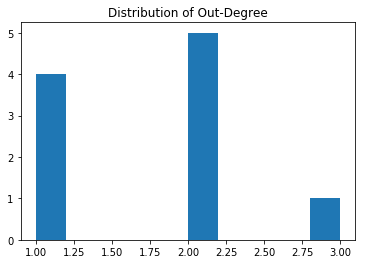

In [43]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
plt.show()

... completed job in 72.41662693023682 seconds
Average out-degree:  32.041815753923544
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]


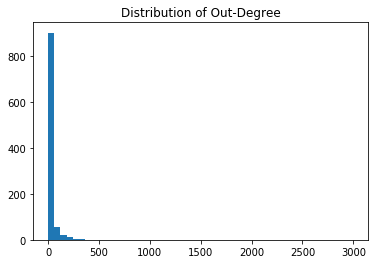

In [44]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
plt.show()

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) short response:__ What is $N$? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to $\frac{1}{N}$. (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute $N$ before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ 

N is the total number of nodes in the graph, including the dangling nodes. We initialize each node to 1/N representing equal probability of going from any node to any other node. 

> __b)__ 

Computing N after initializing all nodes RDD is more efficient.

Finding 'N' involves running a spark job that counts the nodes and the edges to incldue dangling nodes (as done in 5c where we emit records for all nodes including the edges, and perform distinct and count). If we used count_nodes function that we built in 5c to get 'N', we would have to repeat the spark job to build "All Nodes" RDD  (emit records for all nodes including edges, perform distinct and then update state 1/N). Hence, it involves two map-reduce jobs. 

Instead, if we first build all nodes that includes dangling nodes, and then count the resulting RDD, it just involves one map-reduce task.


In [45]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    
    
    #N = count_nodes(dataRDD)
    # We cannot use the function we built before. 
    # We need to build the AllNodes RDD first
    
    # Copying the two helper functions from before to parse and emit nodes
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    def emit_node(line):
        """ Emits nodes """    
        node,edges = line
        yield(node)
        for edge in edges:
            yield(edge)
    def emit_edges_counts(line):
        """ Function to emit the edges and counts"""
        node,edges = line
        yield(node,(edges,sum(edges.values())))
    
    # Now, let us build the ALLNodesRDD with the above
    # It is basically a copy of the function we built to count_nodes
    # except we count after the RDD
    
    ALLNodesRDD = dataRDD.map(lambda x: parse(x)) \
                    .flatMap(emit_node) \
                    .distinct()\
                    .cache()
    
    N = ALLNodesRDD.count()
    initial_score = 1.0/N
    
    # Initialize the nodes with this value
    
    RDD_1 = ALLNodesRDD.map(lambda x: (x, initial_score))
    
    # write your main Spark code here
    RDD_2 = dataRDD.map(lambda x: parse(x)) \
                    .flatMap(emit_edges_counts) 
    
    # Join both so that we get combined result
    # Format = (node_id , (score, edges))
    # This will help us in our next task. We have our initial score set to 1/N
    # Initial state does not matter to the final stable distribution state
    # Also, by having edges and counts together will be easy for the page rank implementation later.
    
    graphRDD = RDD_1.leftOuterJoin(RDD_2).cache()
    
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [102]:
#rdd_test = initGraph(testRDD)
#rdd_test.take(11)

[('4', 0.09090909090909091),
 ('1', 0.09090909090909091),
 ('8', 0.09090909090909091),
 ('9', 0.09090909090909091),
 ('10', 0.09090909090909091),
 ('2', 0.09090909090909091),
 ('3', 0.09090909090909091),
 ('5', 0.09090909090909091),
 ('6', 0.09090909090909091),
 ('7', 0.09090909090909091),
 ('11', 0.09090909090909091)]

In [46]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 1.0876777172088623 seconds.


[('4', (0.09090909090909091, ({'1': 1, '2': 1}, 2))),
 ('10', (0.09090909090909091, ({'5': 1}, 1))),
 ('7', (0.09090909090909091, ({'2': 1, '5': 1}, 2))),
 ('3', (0.09090909090909091, ({'2': 1}, 1))),
 ('6', (0.09090909090909091, ({'2': 1, '5': 1}, 2))),
 ('1', (0.09090909090909091, None)),
 ('8', (0.09090909090909091, ({'2': 1, '5': 1}, 2))),
 ('9', (0.09090909090909091, ({'2': 1, '5': 1}, 2))),
 ('2', (0.09090909090909091, ({'3': 1}, 1))),
 ('5', (0.09090909090909091, ({'4': 1, '2': 1, '6': 1}, 3))),
 ('11', (0.09090909090909091, ({'5': 1}, 1)))]

In [61]:
start = time.time()
test2Graph = initGraph(test2RDD).collect()
print(f'... test2 graph initialized in {time.time() - start} seconds.')
test2Graph

... test2 graph initialized in 3.0561630725860596 seconds.


[('4', (0.09090909090909091, ({'1': 1, '2': 1}, 2))),
 ('10', (0.09090909090909091, ({'5': 1}, 1))),
 ('7', (0.09090909090909091, ({'2': 1, '5': 1}, 2))),
 ('3', (0.09090909090909091, ({'2': 2}, 2))),
 ('6', (0.09090909090909091, ({'2': 1, '5': 2}, 3))),
 ('1', (0.09090909090909091, None)),
 ('8', (0.09090909090909091, ({'2': 1, '5': 1}, 2))),
 ('9', (0.09090909090909091, ({'2': 1, '5': 1}, 2))),
 ('2', (0.09090909090909091, ({'3': 1}, 1))),
 ('5', (0.09090909090909091, ({'4': 3, '2': 1, '6': 1}, 5))),
 ('11', (0.09090909090909091, ({'5': 2}, 2)))]

In [47]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 114.16755771636963 seconds


In [48]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('6171217', (6.582291778908455e-08, ({'10150625': 1, '1823337': 1, '9577051': 1, '8675164': 1, '8296475': 1, '11328087': 1, '10051254': 3, '8831538': 1, '10160486': 1, '5897726': 1, '11699291': 1, '8970958': 2, '8756303': 1, '10373558': 1, '10104515': 1, '13373648': 2, '13204841': 1, '11149576': 1, '7872847': 1}, 23)))]
... initialization continued: 166.1132469177246 seconds


# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='PR-illustrated.png'>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ 

The first term accounts for the probability $\alpha$ at which a random walker can teleport to any other page in the webgraph. Given that there is 1/G chance of landing at any page, the total probability of teleporting becomes $\alpha * \frac{1}{|G|}$

> __b)__ 

m represents the aggregate dangling node mass(i.e sum of probability mass of all the dangling nodes). This mass is equally distributed to each node in the graph, hence each node gets m/G mass from all the dangling nodes (G = Total number of nodes).

> __c)__ Type your answer here! 

Total probability mass must always sum to 1 at each iteration. A little less than 1 is acceptable considering the floating point approximations.

In [49]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [62]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############

    # Here are our rough steps:
    # 1) Find the node count from the RDD and broadcast the same
    # 2) Filter RDD for dangling nodes, and update the dangling mass. Broadcast the result
    # 3) Redistribute the mass to each edge node and yield
    # 4) Reduce (Aggregate) the results
    # 5) Repeat the steps for max Iterations
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.

    
    def ParseInitGraph(line):
        """
        Routine to parse the initial graph and emit node, score, edges separately
        This will help in our subsequent processing
        We have line in the format (('node', (score, ({'edge': weight, 'edge': weight}, edge_count))))
        This function will separate them and return the corresponding values in the format (node,score,dict,edge_count)
        """
        line = ast.literal_eval(line)

        
        # Initialize edge dictionary to None. This is for dangling node
        edgedict = None
        edge_count = 0
        node, score_edge_and_count = line
        score = score_edge_and_count[0]
        edges = score_edge_and_count[1]        
        if edges != None:
            edges = ast.literal_eval(str(edges))
            edgedict = edges[0]
            edge_count = edges[1]
        return (node, score, edgedict, edge_count)

    def redistribute_mass(line):
        
        """        
        Redistribute the mass to the connected nodes.
        We will take the score and divide by the number of neighbbors.
        We should also take the link weights into account here.
        """        
        node, score, edgedict, edge_count = line
        
        if edge_count!=0 :
            # This is not a dangling node.
            # We will calculate the score and emit per neighbor
            
            # Let us first emit the source node, with score as 0 (indicating its processed)
            # along with edge dictionary and edge count.
            yield node, (0, edgedict, edge_count)
            
            # Now for each adjacency node, we calculate the score
            for adjnode in edgedict.keys():
                #  Score with weight (edgedict[adjnode]) considered              
                adjscore = score * edgedict[adjnode]/(edge_count)
                yield adjnode, (adjscore, {}, 0)        
        else: 
            # This is a dangling node. We just need to emit with no score
            yield node, (0, {}, 0)       
    
    def reduce_records(r1, r2):

        """        
        Reducer to aggregate the scores for each node
        """        
        score_1, edgedict_1, edge_count_1 = r1
        score_2, edgedict_2, edge_count_2 = r2
        
        score = score_1 + score_2
        
        # We have one record that has non-null edgedict
        # We need to prefer that record to get dict and count
        
        if len(edgedict_1) > 0:
            edgedict = edgedict_1
            edge_count = edge_count_1
        else:
            edgedict = edgedict_2
            edge_count = edge_count_2
                
        return (score, edgedict, edge_count)
       
 
    def isDangling(line):
        """
        Check if the node is a Dangling node or not
        """
        node, score, edgedict, edge_count = line
        if edge_count == 0:
            return True
        else:
            return False

    def agg_Dangling_mass(line):
        """
        Updates the dangling mass across all dangling nodes.
        """
        node, score, edgedict, edge_count = line
        # Note: initial score is 1/N for each dangling node
        mmAccum.add(score)
        
    def update_total_mass(line):
        """
        Updates the total mass from all nodes
        """
        node, score, edgedict, edge_count = line
        totAccum.add(score)

    def update_pagerank(line):
        """
        Update page rank
        """
        node, rest = line
        score, edgedict, edge_count = rest
        
        # Use the pagerank formula
        updated_score = (a.value * 1/float(G.value))  + (d.value * ((M.value/float(G.value)) + score))
        
        return (node, updated_score, edgedict, edge_count)   
    
        
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    


    # Get the total count and broadcast
    N = graphInitRDD.count()
    G = sc.broadcast(N)
    
    # InitRDD in the format that we want to process
    RDD = graphInitRDD.map(lambda x: ParseInitGraph(str(x))).cache()

    for i in range(maxIter):
        
        #Update dangling mass
        mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        #Apply this to Dangling nodes only.
        RDD.filter(isDangling).foreach(agg_Dangling_mass)
        
        #Broadcast the dangling mass score
        M = sc.broadcast(mmAccum.value)

        RDD = RDD.flatMap(redistribute_mass)\
                 .reduceByKey(lambda a, b: reduce_records(a, b))\
                 .map(update_pagerank).cache()

        if verbose: 
            RDD.foreach(update_total_mass)
            print("Iteration: {}, D_Mass: {}, T_Mass: {}".format(i,mmAccum.value,totAccum.value))        
    
    steadyStateRDD = RDD.map(lambda x: (x[0], x[1])).cache()  
    #return RDD
    ############# (END) YOUR CODE ###############
    return steadyStateRDD

In [63]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

Iteration: 0, D_Mass: 0.09090909090909091, T_Mass: 1.0
Iteration: 1, D_Mass: 0.059297520661157024, T_Mass: 1.0
Iteration: 2, D_Mass: 0.03794640621086902, T_Mass: 0.9999999999999997
Iteration: 3, D_Mass: 0.06401906959337932, T_Mass: 0.9999999999999998
Iteration: 4, D_Mass: 0.037595964795097685, T_Mass: 0.9999999999999998
Iteration: 5, D_Mass: 0.038674936390503456, T_Mass: 0.9999999999999998
Iteration: 6, D_Mass: 0.03411772573816476, T_Mass: 0.9999999999999997
Iteration: 7, D_Mass: 0.03465268558210355, T_Mass: 0.9999999999999996
Iteration: 8, D_Mass: 0.03326414799094906, T_Mass: 0.9999999999999998
Iteration: 9, D_Mass: 0.03326870680631062, T_Mass: 0.9999999999999996
Iteration: 10, D_Mass: 0.032930101786204716, T_Mass: 0.9999999999999996
Iteration: 11, D_Mass: 0.03291944436426479, T_Mass: 0.9999999999999997
Iteration: 12, D_Mass: 0.032828289346332, T_Mass: 0.9999999999999997
Iteration: 13, D_Mass: 0.03281973841665034, T_Mass: 0.9999999999999996
Iteration: 14, D_Mass: 0.03279573415109754, 

[('2', 0.38031552249156747),
 ('3', 0.3469932932917438),
 ('5', 0.08088637369406641),
 ('4', 0.039087602168414746),
 ('6', 0.039087602168414746),
 ('1', 0.032781877034008526),
 ('10', 0.01616954583035677),
 ('7', 0.01616954583035677),
 ('8', 0.01616954583035677),
 ('9', 0.01616954583035677),
 ('11', 0.01616954583035677)]

__`expected results for the test graph:`__
```
(2, 0.3803155224915675)
(3, 0.3469932932917439)
(5, 0.08088637369406641)
(4, 0.039087602168414746)
(6, 0.039087602168414746)
(1, 0.032781877034008526)
(8, 0.01616954583035677)
(10, 0.01616954583035677)
(7, 0.01616954583035677)
(9, 0.01616954583035677)
(11, 0.01616954583035677)
```

In [64]:
# part d - run PageRank on the test2 graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
test2GraphRDD = initGraph(test2RDD)
start = time.time()
test2_results = runPageRank(test2GraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test2_results.takeOrdered(20, key=lambda x: - x[1])

Iteration: 0, D_Mass: 0.09090909090909091, T_Mass: 0.9999999999999998
Iteration: 1, D_Mass: 0.059297520661157024, T_Mass: 0.9999999999999998
Iteration: 2, D_Mass: 0.046703981968444774, T_Mass: 0.9999999999999998
Iteration: 3, D_Mass: 0.09925338433167132, T_Mass: 0.9999999999999998
Iteration: 4, D_Mass: 0.050342917879662344, T_Mass: 0.9999999999999999
Iteration: 5, D_Mass: 0.05145916544900261, T_Mass: 0.9999999999999998
Iteration: 6, D_Mass: 0.04500922379221685, T_Mass: 0.9999999999999996
Iteration: 7, D_Mass: 0.04715082459390296, T_Mass: 0.9999999999999997
Iteration: 8, D_Mass: 0.04374695430399097, T_Mass: 0.9999999999999996
Iteration: 9, D_Mass: 0.04376323453143378, T_Mass: 0.9999999999999998
Iteration: 10, D_Mass: 0.04298252973766269, T_Mass: 0.9999999999999998
Iteration: 11, D_Mass: 0.04301289483938668, T_Mass: 0.9999999999999997
Iteration: 12, D_Mass: 0.04272340069209819, T_Mass: 0.9999999999999996
Iteration: 13, D_Mass: 0.04269860289957524, T_Mass: 0.9999999999999998
Iteration: 14

[('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624556),
 ('4', 0.06030963508473455),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('10', 0.01692511778009981),
 ('7', 0.01692511778009981),
 ('8', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('11', 0.01692511778009981)]

In [65]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

Iteration: 0, D_Mass: 0.6194586236199783, T_Mass: 1.0000000000038185
Iteration: 1, D_Mass: 0.49623665522464117, T_Mass: 1.0000000000031979
Iteration: 2, D_Mass: 0.45845896640091266, T_Mass: 1.0000000000027662
Iteration: 3, D_Mass: 0.44518624579783966, T_Mass: 1.0000000000027123
Iteration: 4, D_Mass: 0.44020147818723804, T_Mass: 1.0000000000019298
Iteration: 5, D_Mass: 0.43818412109703164, T_Mass: 1.0000000000014084
Iteration: 6, D_Mass: 0.4373267618639368, T_Mass: 1.0000000000013456
Iteration: 7, D_Mass: 0.43694515814505175, T_Mass: 1.0000000000016598
Iteration: 8, D_Mass: 0.43676848972075516, T_Mass: 1.000000000001332
Iteration: 9, D_Mass: 0.43668343042804153, T_Mass: 1.0000000000014009
...trained 10 iterations in 2016.4881465435028 seconds.
Top 20 ranked nodes:


[('13455888', 0.0015447247129827058),
 ('4695850', 0.0006710240718904011),
 ('5051368', 0.0005983856809745467),
 ('1184351', 0.0005982073536465467),
 ('2437837', 0.0004624928928938975),
 ('6076759', 0.00045509400641431566),
 ('4196067', 0.00044237788883707933),
 ('13425865', 0.0004415535171433002),
 ('6172466', 0.0004224002001843472),
 ('1384888', 0.0004012895604072398),
 ('6113490', 0.0003957892477179322),
 ('14112583', 0.0003943847283753156),
 ('7902219', 0.00037009878473555287),
 ('10390714', 0.0003650264964326863),
 ('12836211', 0.0003619948863113367),
 ('6237129', 0.00035195558476239393),
 ('6416278', 0.0003486623564525345),
 ('13432150', 0.00033936510637404624),
 ('1516699', 0.0003329750028623157),
 ('7990491', 0.0003076090626585675)]